# CD73-Positive Cell Spheroid Transplantation Attenuates Colonic Atrophy

Here we will use DESeq2 to perform differential gene expression analysis

As was already stated in the previous notebook, the upregulation of certain genes is expected to be observed in CD73 samples, though it did not seem obvious upon initial inspection:

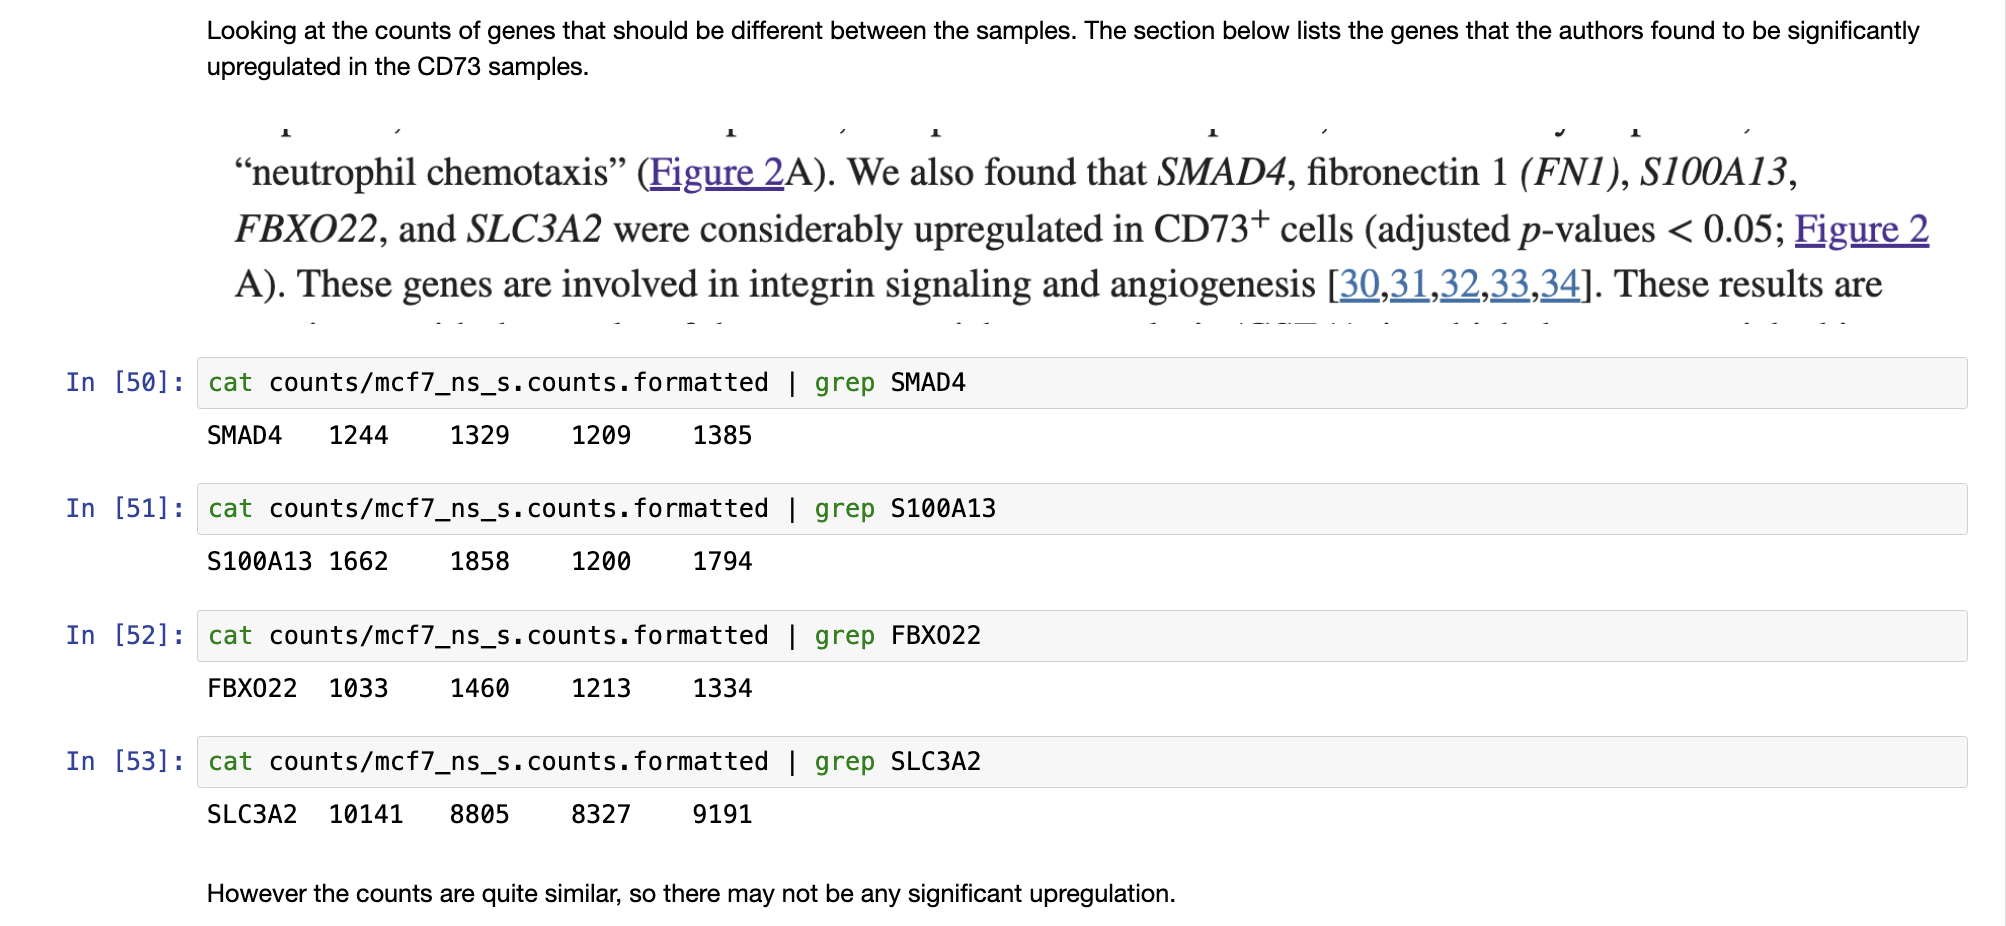

## Step 0: Setting up the working directory

In [45]:
USER <- Sys.getenv("USER")
setwd(paste0("/mnt/storage/",USER,"/jupyternotebooks/task1"))

## Step 1: Loading the data

Loading the count matrix, which was generated using `Assignment1_part1`

In [2]:
cts <- as.matrix(read.csv("counts/mcf7_ns_s.counts.formatted", sep="\t", row.names = "Geneid"))

In [3]:
head(cts, 5)

,CD73_1_p,CD73_2_p,cMSC_1_p,cMSC_2_p
DDX11L1,0,0,0,0
WASH7P,0,2,0,2
MIR6859-1,0,0,2,1
MIR1302-2HG,0,0,0,0
MIR1302-2,0,0,0,0


Note: The _p extension was added because the samples were filtered using fastp in the previous notebook

Generating a dataframe with the metadata:

In [11]:
coldata <- data.frame(
    row.names = c("CD73_1_p", "CD73_2_p", "cMSC_1_p", "cMSC_2_p"),
    condition = c("CD73", "CD73", "cMSC", "cMSC") 
)

In [12]:
coldata

,condition
,<fct>
CD73_1_p,CD73
CD73_2_p,CD73
cMSC_1_p,cMSC
cMSC_2_p,cMSC


In [13]:
all(rownames(coldata) == colnames(cts))

[1] TRUE

Constructing the DESeqDataSet:

In [14]:
suppressWarnings(library("DESeq2"))
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)
dds

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

class: DESeqDataSet 
dim: 56505 4 
metadata(1): version
assays(1): counts
rownames(56505): DDX11L1 WASH7P ... AC007325.4 AC007325.2
rowData names(0):
colnames(4): CD73_1_p CD73_2_p cMSC_1_p cMSC_2_p
colData names(1): condition

The cMSC cells will be set as the control group. 

In [15]:
dds$condition <- factor(dds$condition, levels = c("cMSC","CD73"))

Prefiltering to only keep genes that have a count of at least 10 for a minimum of 2 samples

In [16]:
smallestGroupSize <- 2
keep <- rowSums(counts(dds) >= 10) >= smallestGroupSize
dds <- dds[keep,]

## Step 2: Modelling read counts and performing differential expression analysis

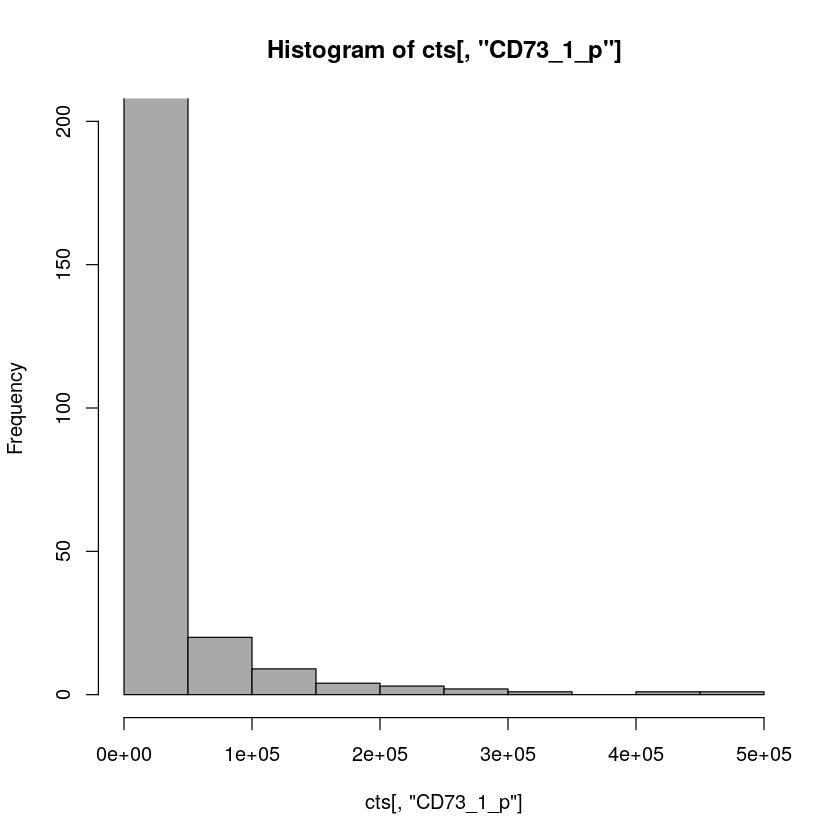

In [18]:
hist(cts[, 'CD73_1_p'], ylim=c(0, 200), col = "darkgray")

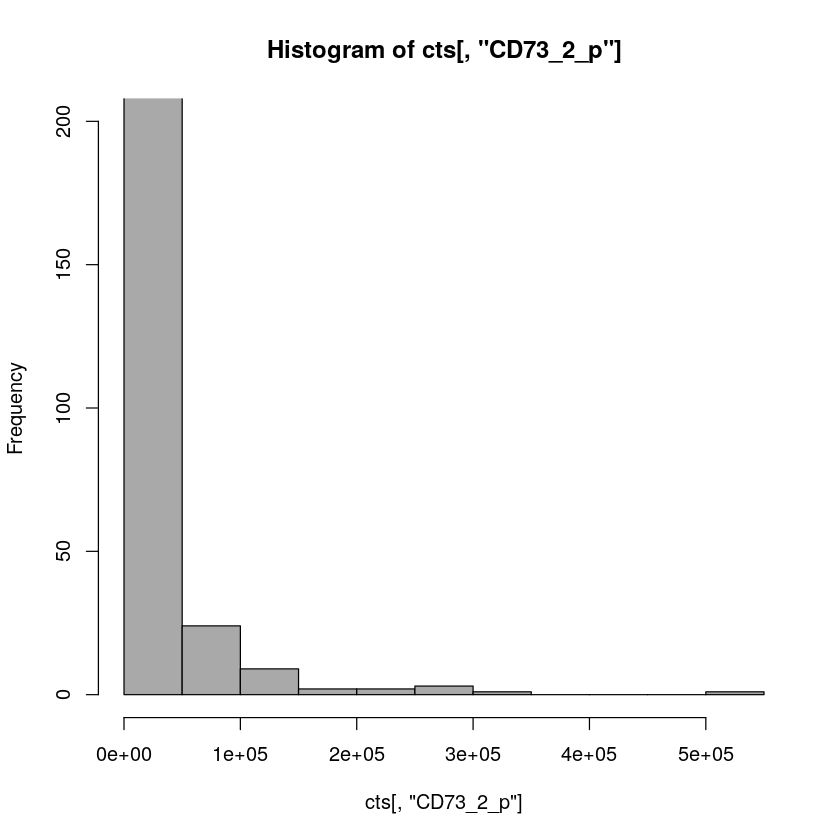

In [19]:
hist(cts[, 'CD73_2_p'], ylim=c(0, 200), col = "darkgray")

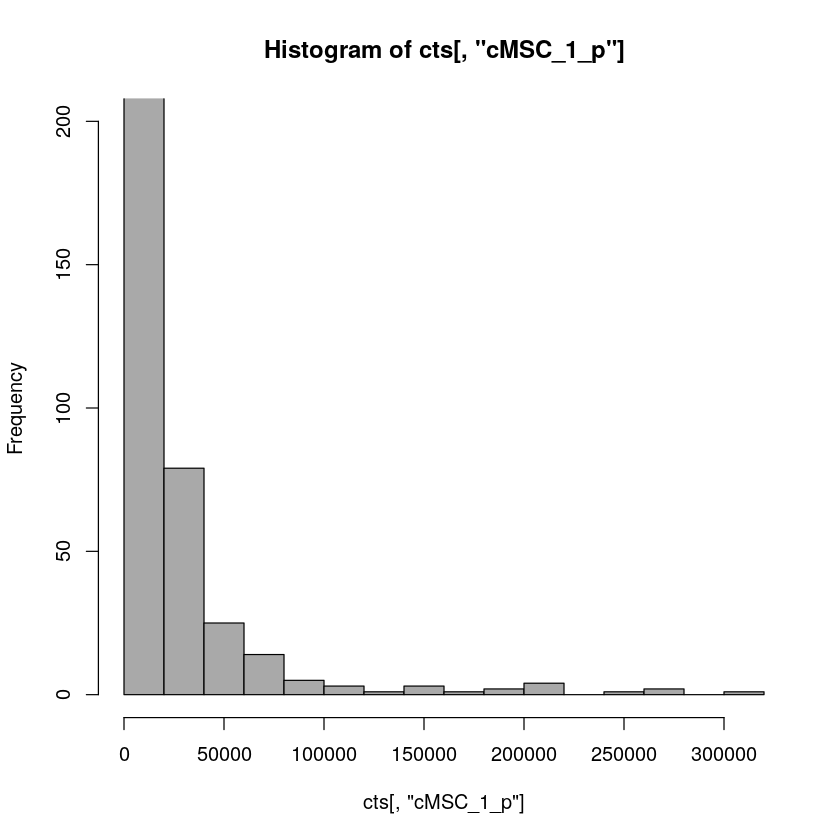

In [20]:
hist(cts[, 'cMSC_1_p'], ylim=c(0, 200), col = "darkgray")

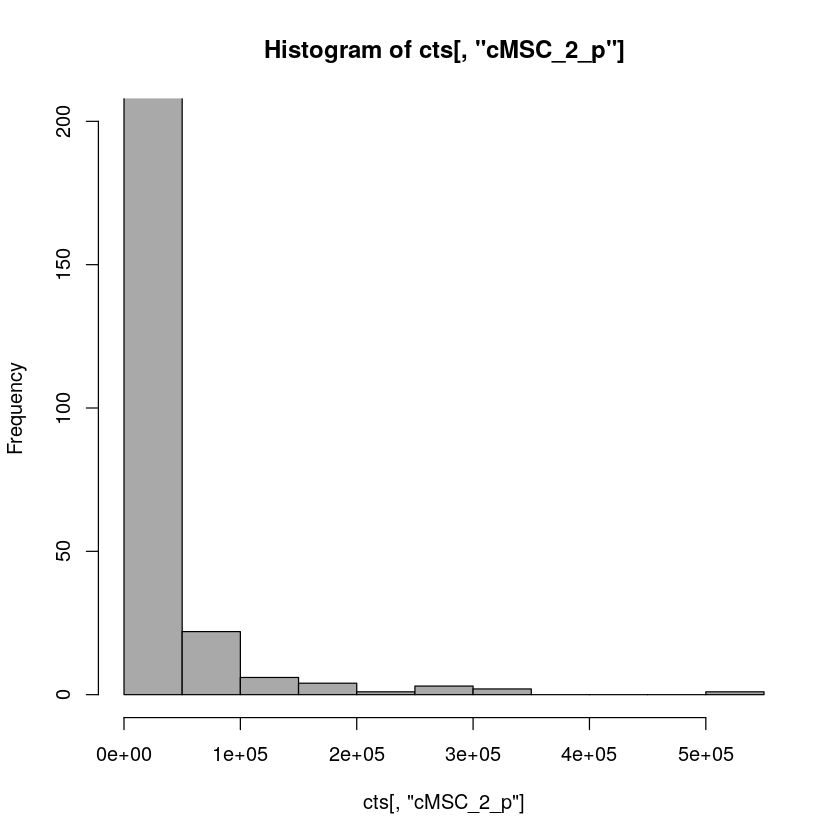

In [21]:
hist(cts[, 'cMSC_2_p'], ylim=c(0, 200), col = "darkgray")

The distribution is not normal for any of the samples. 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


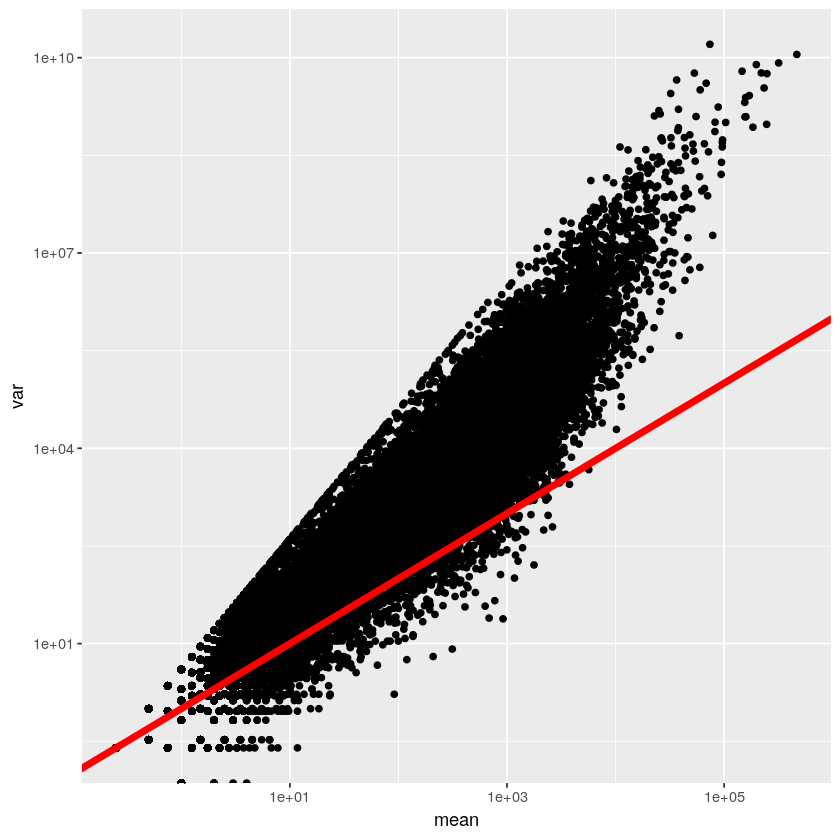

In [22]:
library(ggplot2)
data <- data.frame(
    mean = rowMeans(cts[rowSums(cts) != 0, ]),
    var  = rowVars(cts[rowSums(cts) != 0, ]))
ggplot(data, aes(x = mean, y = var)) +
    geom_point() +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10") +
    geom_abline(intercept = 0, slope = 1, color = "red", size = 2)

The red line does not properly fit the data, therefore some adjustments are necessary. 

In [23]:
dds <- DESeq(dds)
res <- results(dds)
res

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition CD73 vs cMSC 
Wald test p-value: condition CD73 vs cMSC 
DataFrame with 15311 rows and 6 columns
                      baseMean      log2FoldChange             lfcSE
                     <numeric>           <numeric>         <numeric>
MTND2P28      419.742828459706   0.158327471153288  2.75658355467517
MTCO1P12      42.9062494678833   0.503211019437821  0.59550825930436
MTATP6P1      1700.66435271233   0.190194545645416 0.511183865528816
RP11-206L10.9 8.10796271835619   0.556454795871902  1.45965433715703
RP11-206L10.8 7.61700924131884 0.00761535038089289  1.56543927740728
...                        ...                 ...               ...
MT-TP         22.0710267251687   0.575858092484978  1.19936218463829
AC011043.1    144.119726399142   0.142281367975199  1.29597827215294
AL592183.1    53.1819875563387    0.13846998717128 0.847210995026675
AC240274.1    86.2468504549589   0.100943999284026 0.660380570406973
AC004556.1    111.014903341835   -0.46487

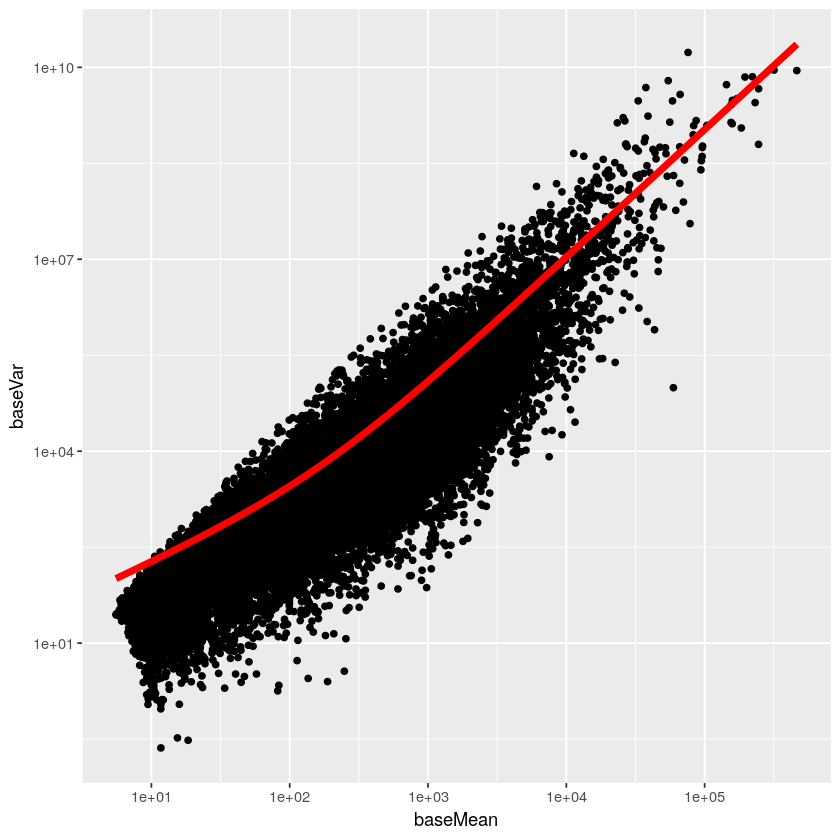

In [24]:
ggplot(as.data.frame(mcols(dds)[!mcols(dds)$allZero, ])) +
    geom_point(aes(x = baseMean, y = baseVar )) + 
    geom_line(aes(x = baseMean, y = baseMean + dispFit * baseMean * baseMean ), color = "red", size = 2) +
    scale_x_continuous(trans = "log10") +
    scale_y_continuous(trans = "log10")

The red line fits the data better.

Genes with a low read count are expected to have a highly variable log2FoldChange. This will cause issues if we want to rank genes based on their log2fold change values.

An obvious issue that's clear here, is that there seem to be very few genes with a significant p value. This would indicate that there is probably no significant up or down regulation. 

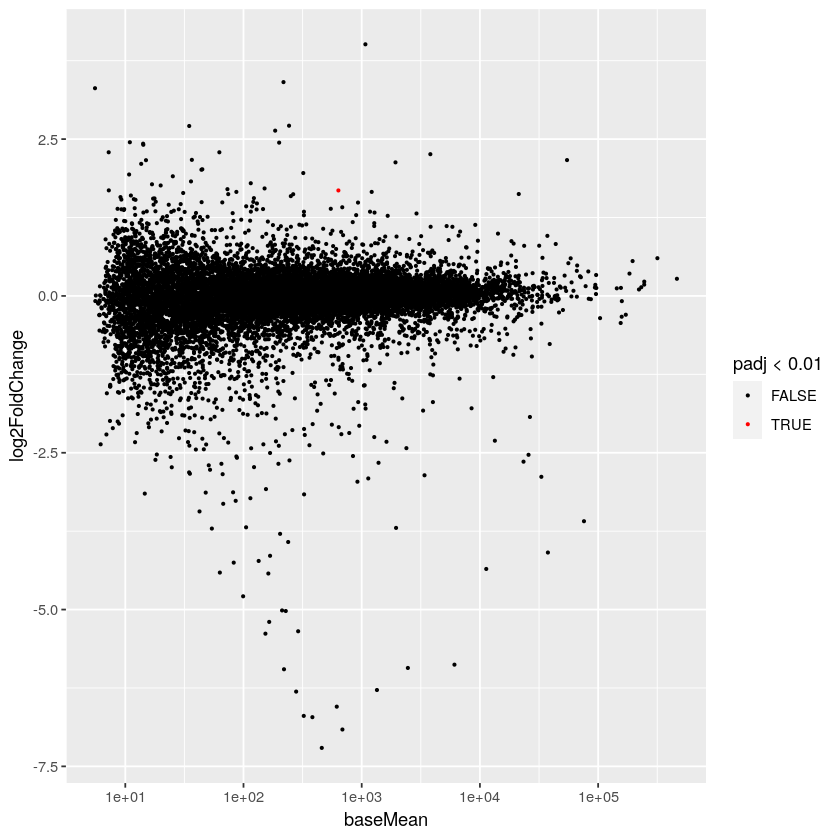

In [25]:
ggplot(as.data.frame(res), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

Warning message:
“Removed 84 rows containing missing values (`geom_point()`).”


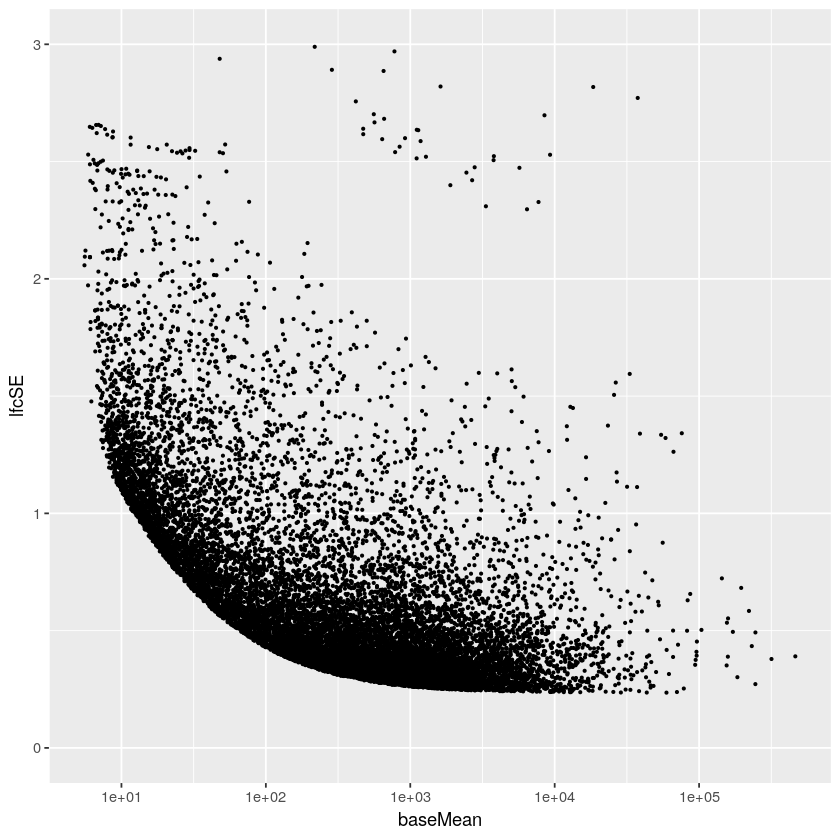

In [26]:
ggplot(as.data.frame(res), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

In [27]:
resultsNames(dds)

[1] "Intercept"              "condition_CD73_vs_cMSC"

In [28]:
resLFC <- lfcShrink(dds, coef="condition_CD73_vs_cMSC")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [29]:
resLFC

log2 fold change (MAP): condition CD73 vs cMSC 
Wald test p-value: condition CD73 vs cMSC 
DataFrame with 15311 rows and 6 columns
                      baseMean       log2FoldChange              lfcSE
                     <numeric>            <numeric>          <numeric>
MTND2P28      419.742828459706  0.00228651359629848 0.0398465530994732
MTCO1P12      42.9062494678833    0.120032185067143  0.142517591013933
MTATP6P1      1700.66435271233   0.0568370863814313  0.152839836496378
RP11-206L10.9 8.10796271835619   0.0274295315573092 0.0726951307802023
RP11-206L10.8 7.61700924131884 0.000330621265418249 0.0680982349552677
...                        ...                  ...                ...
MT-TP         22.0710267251687   0.0410167903164204 0.0863314103175442
AC011043.1    144.119726399142  0.00884643579450677 0.0806474623867862
AL592183.1    53.1819875563387   0.0186136621109481  0.113874231552947
AC240274.1    86.2468504549589   0.0205406173576836  0.134419075413743
AC004556.1    111

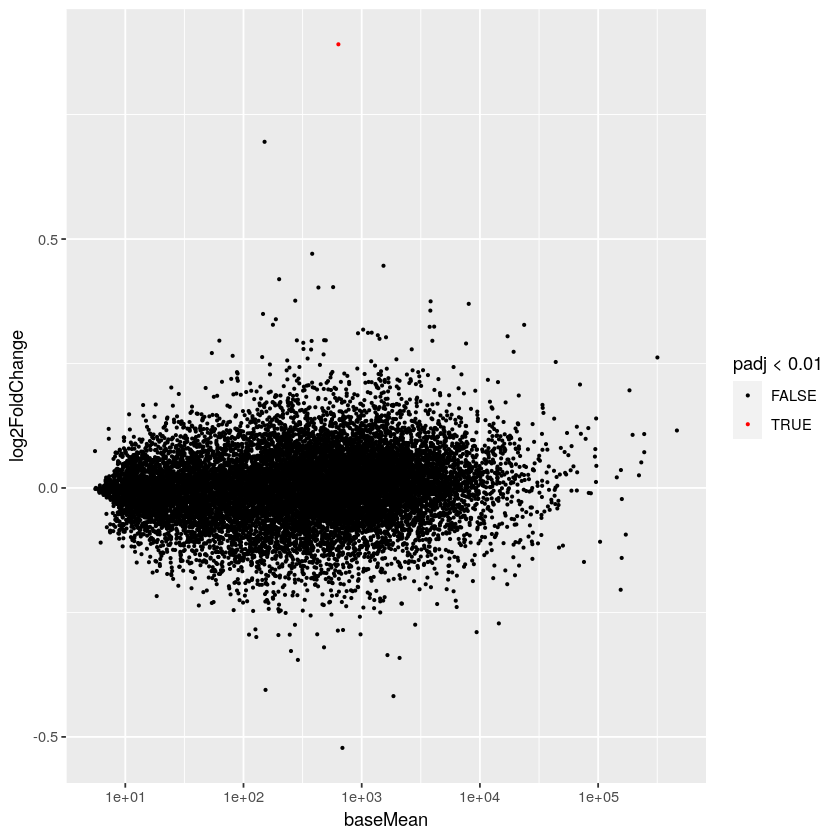

In [30]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = log2FoldChange)) +
    geom_point(aes(colour = padj < 0.01), size = 0.5) +
    scale_x_continuous(trans = "log10") +
    scale_color_manual(name = "padj < 0.01", values = setNames(c("red", "black"), c(T, F)))

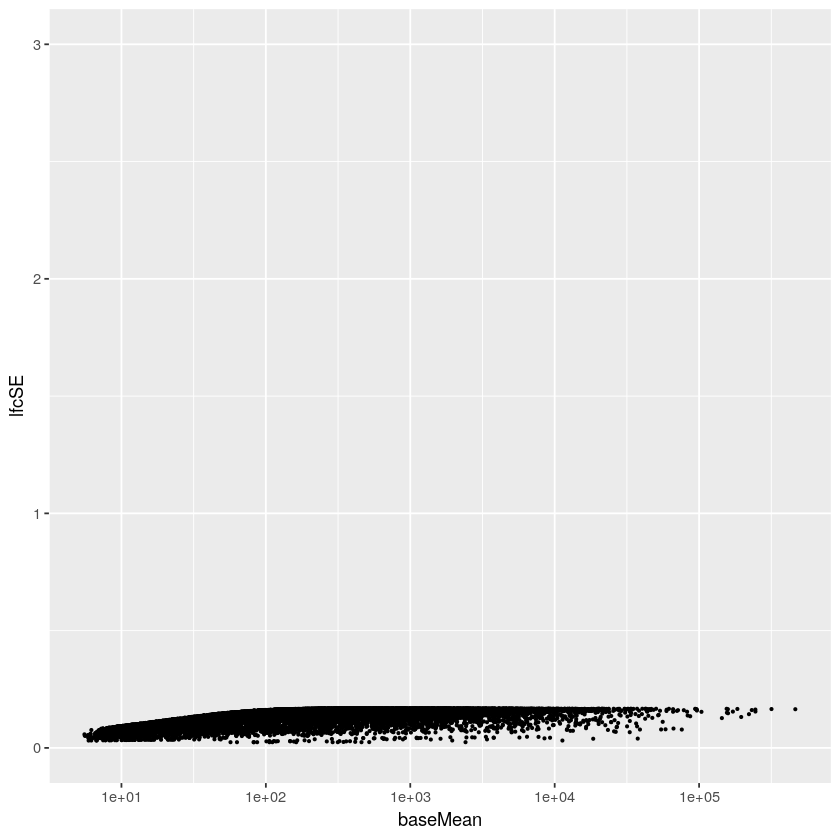

In [31]:
ggplot(as.data.frame(resLFC), aes(x = baseMean, y = lfcSE)) +
    geom_point(size = 0.5) +
    scale_x_continuous(trans = "log10") +
    ylim(0, 3)

The effect of the variance is much smaller now.

## Step 3: Downstream analysis

### Getting a list of up- or downregulated genes

In [32]:
suppressWarnings(library(dplyr))


Attaching package: ‘dplyr’


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [33]:
resLFC_df <- as.data.frame(resLFC)

In [34]:
resLFC_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MTND2P28,419.742828,0.0022865136,0.03984655,0.057436123,0.9541978,0.9998814
MTCO1P12,42.906249,0.1200321851,0.14251759,0.845010983,0.3981047,0.9998814
MTATP6P1,1700.664353,0.0568370864,0.15283984,0.372066801,0.7098431,0.9998814
RP11-206L10.9,8.107963,0.0274295316,0.07269513,0.381223679,0.7030373,0.9998814
RP11-206L10.8,7.617009,0.0003306213,0.06809823,0.004864673,0.9961186,0.9998814
FAM87B,346.040383,0.1112412004,0.15134841,0.736601088,0.4613650,0.9998814
LINC01128,312.598368,0.0155585906,0.12865369,0.120967954,0.9037164,0.9998814
LINC00115,24.620284,-0.0017794440,0.12021691,-0.014799695,0.9881920,0.9998814
RP11-54O7.1,9.681400,-0.0045550340,0.04696180,-0.097075943,0.9226661,0.9998814


In [48]:
write.csv(resLFC_df, 
          file="deseq.results.csv", quote=FALSE)

Defining the thresholds:

In [36]:
log2FC_thr = 1
pad_thr = 0.01

In [37]:
upregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange > log2FC_thr, padj < pad_thr))

In [38]:
upregulated_genes

character(0)

In [39]:
downregulated_genes <- row.names(resLFC_df %>% 
    filter(log2FoldChange < log2FC_thr, padj < pad_thr))

In [40]:
downregulated_genes

[1] "MT-ND6"

There are no significantly upregulated genes and only 1 significantly down regulated gene, if we only look at the p values. This is highly unexpected since the paper stated that there were up and down regulated genes:
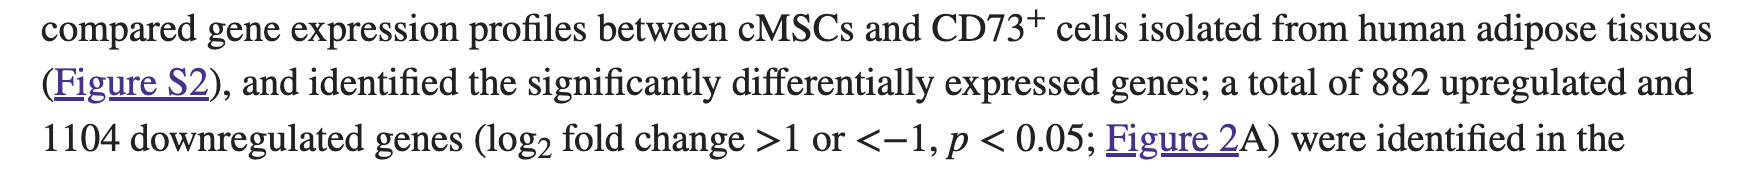

## Sorting the gene list based on log2FC values

In [41]:
resLFC_df %>%
    arrange(log2FoldChange)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1RL,686.8114,-0.5220534,0.1664489,-3.160358,0.001575754,0.9998814
SLC39A7,1855.8764,-0.4180685,0.1649735,-2.538017,0.011148271,0.9998814
CTSZ,153.5993,-0.4055635,0.1653682,-2.464453,0.013722256,0.9998814
ATOH8,288.4204,-0.3453338,0.1618576,-2.149567,0.031589448,0.9998814
BAX,2090.4985,-0.3413513,0.1646682,-2.074938,0.037992292,0.9998814
FADS2,1651.0146,-0.3356679,0.1644053,-2.052577,0.040113612,0.9998814
CKAP2L,252.2004,-0.3274868,0.1668660,-1.966434,0.049248471,0.9998814
RAD23B,479.9975,-0.3200933,0.1657854,-1.932491,0.053298965,0.9998814
PATL1,128.3441,-0.2993722,0.1586100,-1.901079,0.057291697,0.9998814


In [47]:
sorted_resLFC_df <- resLFC_df %>%
    arrange(log2FoldChange)
write.csv(sorted_resLFC_df, 
          file="LFC_sorted_deseq.results.csv", quote=FALSE)

To better understand the difference between the samples and the genes that are active, we need to perform functional analysis of the gene signatures.

### Plotting a heatmap

In [42]:
library(pheatmap)

In [43]:
pheatmap(cts[c(upregulated_genes, downregulated_genes), ], scale = "row", show_rownames = F)

Warning message in min(x, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = T):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in seq.default(-m, m, length.out = n + 1): 'from' must be a finite number


It wasn't possible to plot a heatmap because significantly up or down regulated genes were not found, using the thresholds set above. The paper did not clearly explain how this analysis was performed by the authors, therefore, to continue the analysis, the top 100 and bottom 100 genes will be considered as significantly up/down-regulated. 